In [307]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [308]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self._prev = set(_children)
        self._backward = lambda:None
        self._op = _op
        self.label = label
        self.grad = 0.0
        
    def __repr__(self) -> str:
        return f'Value(data={self.data})'
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float for now"
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            # See power rule here: https://en.wikipedia.org/wiki/Power_rule
            self.grad += (other * self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other): # other * self
        return self * other
    
    
    # a / b is the same as below ...
    # a * 1 / b
    # a * b**-1
    def __truediv__(self, other):
        return self * other**-1
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        def _backward():
            self.grad += (1 - t**2) * out.grad
        
        out  = Value(t, (self,), 'tanh')
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        
        
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [309]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [310]:
from graphviz import Digraph

def trace(root):
    # build a  set of all nodes and edges in a graph
    nodes, edges, = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the grap, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label,n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label= n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
        
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

# A neuron
![A single neuron](./one_neuron.jpg)
# Activation function Tan h
![Tan H](./tanh.png)


![Derivative of tanh](./derivative_of_tanh.png)

In [311]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weight w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1_plus_x2w2 = x1w1 + x2w2; x1w1_plus_x2w2.label = 'x1w1 + x2w2'
n = x1w1_plus_x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

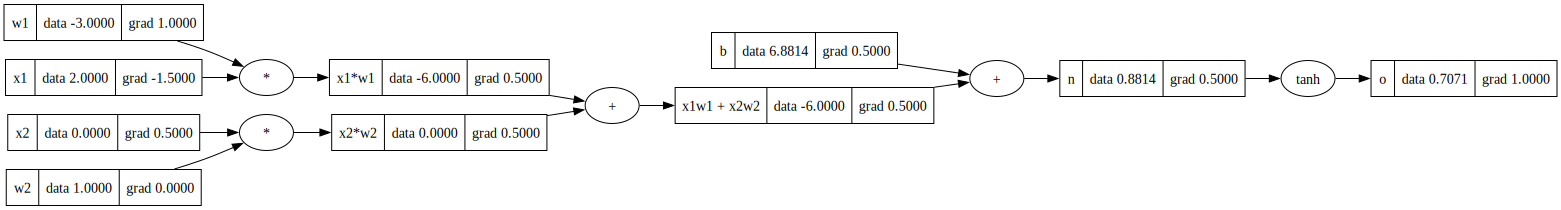

In [312]:
draw_dot(o)

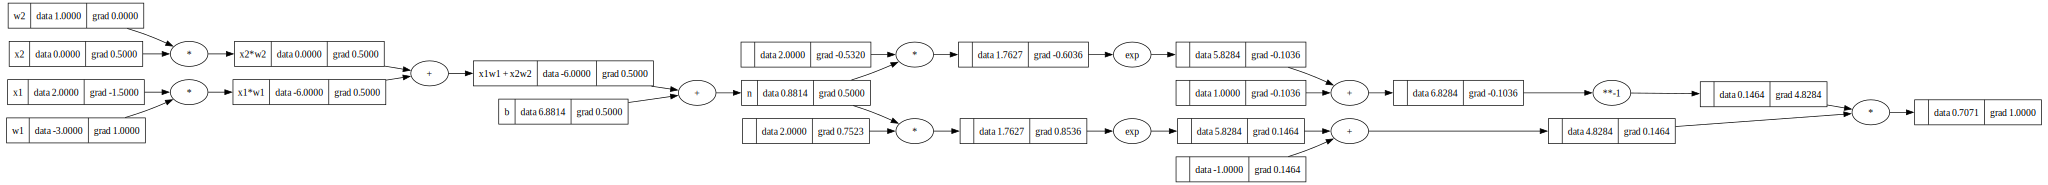

In [313]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weight w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1_plus_x2w2 = x1w1 + x2w2; x1w1_plus_x2w2.label = 'x1w1 + x2w2'
n = x1w1_plus_x2w2 + b; n.label = 'n'
# ---- Reimplement tanh using e**2*x  - 1 / e**2*x + 1
o =  ((2 * n).exp() - 1) / ((2 * n).exp() + 1)
# ----

o.backward()
draw_dot(o)

In [314]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


![multi_layer_neural_network.png](multi_layer_neural_network.png)

In [334]:
import random

class Neuron:
    def __init__(self, nin) -> None:
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params
    
class MLP:
    def __init__(self, nin, nouts) -> None:
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.845029404878086)

In [335]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [340]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys, ypred)])
    
    # very important to reset gradients to zero before backpropagating
    for p in n.parameters():
        p.grad = 0.0
    
    # backward pass
    loss.backward()
    
    # update parameters
    for p in n.parameters():
        p.data += -0.05 * p.grad 
    print(k, loss.data)
    

0 0.016237616140201007
1 0.01575857341663769
2 0.015304653860702013
3 0.014873981731649027
4 0.01446486152174299
5 0.014075756946844015
6 0.013705272796822059
7 0.01335213920307454
8 0.013015197956878765
9 0.012693390574250707
10 0.012385747853404181
11 0.012091380712134003
12 0.011809472126310937
13 0.011539270018599846
14 0.011280080969637181
15 0.011031264643120004
16 0.010792228832292448
17 0.010562425048735245
18 0.01034134458563931
19 0.010128514997243687


In [341]:
ypred

[Value(data=0.9453770772816898),
 Value(data=-0.9563121230474338),
 Value(data=-0.9448654466345576),
 Value(data=0.953134215641645)]